In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
        self.mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert to binary mask
        mask = (mask > 0).float()
        return image, mask

# 2️⃣ Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# 3️⃣ Dataloaders
train_dataset = PlantDiseaseDataset("Plant_Disease_Data/aug_data/train_images",
                                    "Plant_Disease_Data/aug_data/train_masks", transform)
val_dataset = PlantDiseaseDataset("Plant_Disease_Data/aug_data/valid_images",
                                  "Plant_Disease_Data/aug_data/valid_masks", transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


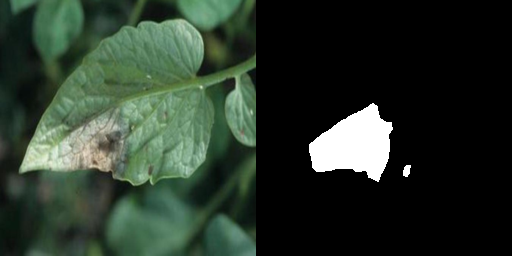

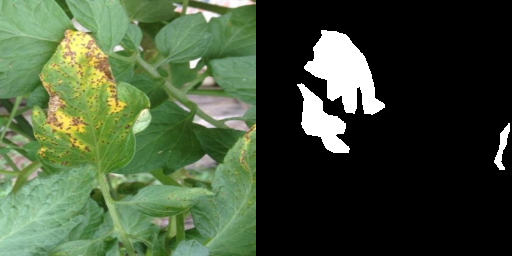

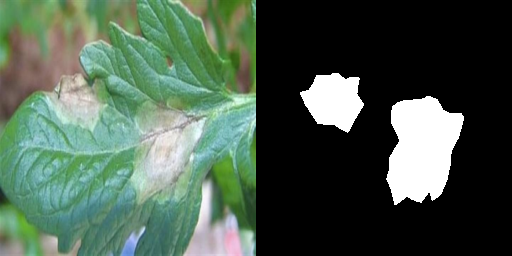

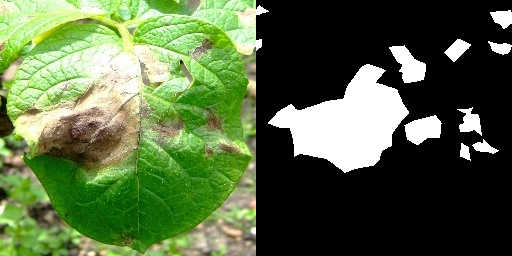

In [4]:
import random
from PIL import Image
import numpy as np
from IPython.display import display
import torch

def show_batch_from_dataloader(data_loader, num_images=4):
    # Get one batch
    for images, masks in data_loader:
        break  # We just need the first batch
    
    batch_size = images.shape[0]
    indices = random.sample(range(batch_size), min(num_images, batch_size))

    for idx in indices:
        image = images[idx]
        mask = masks[idx]

        # Convert tensors to numpy
        image_np = image.permute(1, 2, 0).numpy()
        mask_np = mask.squeeze().numpy()

        # Scale to 0–255 if needed
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)
        else:
            image_np = image_np.astype(np.uint8)

        mask_np = (mask_np * 255).astype(np.uint8)

        # Convert to PIL
        image_pil = Image.fromarray(image_np)
        mask_pil = Image.fromarray(mask_np).convert("L").convert("RGB")

        # Combine side by side
        combined = Image.new("RGB", (image_pil.width + mask_pil.width, image_pil.height))
        combined.paste(image_pil, (0, 0))
        combined.paste(mask_pil, (image_pil.width, 0))

        # Display in notebook
        display(combined)
show_batch_from_dataloader(train_loader, num_images=4)


In [5]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# 4️⃣ UNet Architecture
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        b = self.bottleneck(self.pool2(d2))
        u2 = self.up2(b)
        dc2 = self.dec2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(dc2)
        dc1 = self.dec1(torch.cat([u1, d1], dim=1))
        out = self.final_conv(dc1)
        return out

# 5️⃣ Training Setup
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



cuda


In [8]:
MODEL_PATH = "plant_disease_unet.pth"
def save_model():
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"✅ Model saved to {MODEL_PATH}")

def load_model():
    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        print(f"🔄 Loaded model weights from {MODEL_PATH}")
    else:
        print("⚠️ No saved model found. Starting fresh.")

In [9]:
# 6️⃣ Training Loop
def train_model(epochs=3):
    load_model()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device).squeeze(1)
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
        save_model()  # Save after each epoch
train_model(epochs=10)


C:\Users\Ruthwik Reddy\AppData\Local\Temp\ipykernel_4380\2762403679.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_loca

🔄 Loaded model weights from plant_disease_unet.pth
Epoch [1/10], Loss: 142.6537
✅ Model saved to plant_disease_unet.pth
Epoch [2/10], Loss: 137.9349
✅ Model saved to plant_disease_unet.pth
Epoch [3/10], Loss: 136.5149
✅ Model saved to plant_disease_unet.pth
Epoch [4/10], Loss: 133.1156
✅ Model saved to plant_disease_unet.pth
Epoch [5/10], Loss: 130.0448
✅ Model saved to plant_disease_unet.pth
Epoch [6/10], Loss: 127.9127
✅ Model saved to plant_disease_unet.pth
Epoch [7/10], Loss: 126.6967
✅ Model saved to plant_disease_unet.pth
Epoch [8/10], Loss: 122.9521
✅ Model saved to plant_disease_unet.pth
Epoch [9/10], Loss: 121.0556
✅ Model saved to plant_disease_unet.pth
Epoch [10/10], Loss: 117.7197
✅ Model saved to plant_disease_unet.pth


Raw pred -> min: 0.5113, max: 0.5155, mean: 0.5135


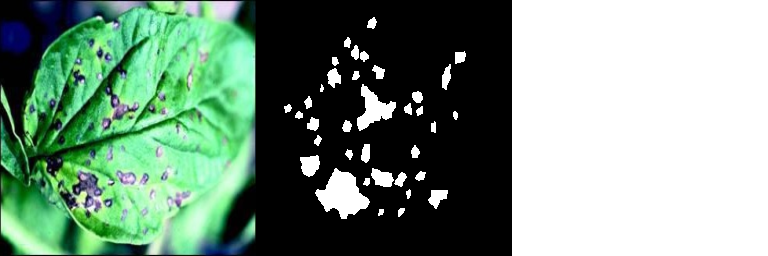

Raw pred -> min: 0.5112, max: 0.5144, mean: 0.5125


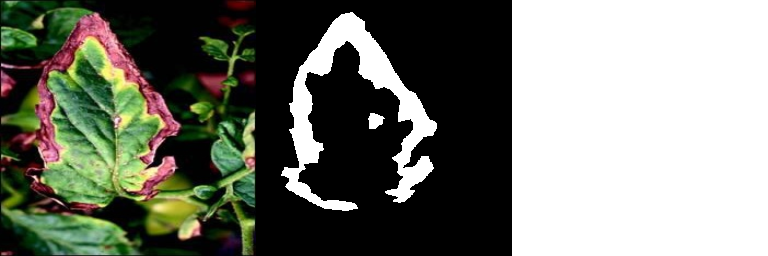

Raw pred -> min: 0.5111, max: 0.5155, mean: 0.5135


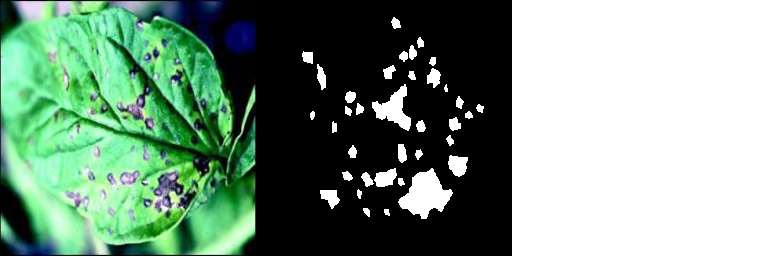

Raw pred -> min: 0.5114, max: 0.5154, mean: 0.5128


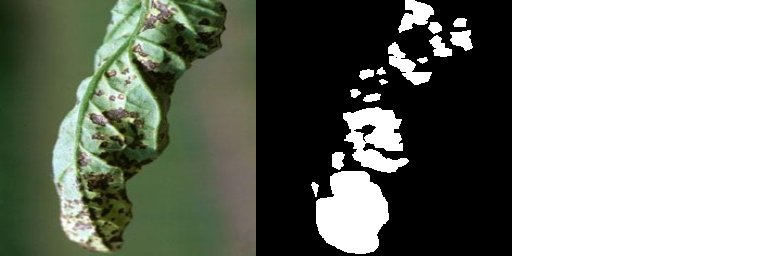

In [12]:
import random
from PIL import Image
from IPython.display import display
import numpy as np
import torch

def evaluate(num_images=4):
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            outputs = torch.sigmoid(model(images)).cpu()

            batch_size = images.shape[0]
            indices = random.sample(range(batch_size), min(num_images, batch_size))

            for idx in indices:
                img = images[idx].cpu()
                mask = masks[idx].cpu()
                pred = outputs[idx].cpu()

                # Convert tensors to numpy
                img_np = img.permute(1, 2, 0).numpy()
                mask_np = mask.squeeze().numpy()
                pred_np = pred.squeeze().numpy()

                # 🔍 Print prediction stats BEFORE thresholding
                print(f"Raw pred -> min: {pred_np.min():.4f}, max: {pred_np.max():.4f}, mean: {pred_np.mean():.4f}")

                # Scale image to 0–255 if needed
                if img_np.max() <= 1.0:
                    img_np = (img_np * 255).astype(np.uint8)
                else:
                    img_np = img_np.astype(np.uint8)

                mask_np = (mask_np * 255).astype(np.uint8)
                
                # Threshold for visualization
                pred_np_vis = (pred_np > 0.5).astype(np.uint8) * 255

                # Convert to PIL
                img_pil = Image.fromarray(img_np)
                mask_pil = Image.fromarray(mask_np).convert("L").convert("RGB")
                pred_pil = Image.fromarray(pred_np_vis).convert("L").convert("RGB")

                # Combine side by side
                combined = Image.new("RGB", (img_pil.width * 3, img_pil.height))
                combined.paste(img_pil, (0, 0))
                combined.paste(mask_pil, (img_pil.width, 0))
                combined.paste(pred_pil, (img_pil.width * 2, 0))

                # Display in notebook
                display(combined)
            break  # Just one batch

evaluate(num_images=4)


In [10]:
print(f"Pred min: {pred_np.min():.4f}, max: {pred_np.max():.4f}, mean: {pred_np.mean():.4f}")


NameError: name 'pred_np' is not defined